In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cte
from scipy.optimize import minimize, brentq
from scipy.integrate import quad
import corner
import emcee

%matplotlib inline

## Datasets

### CMB

In [2]:
l_cmb = 302.
err_l_cmb = 0.2
z_ls = 1090.

theta_cmb = np.pi / l_cmb
err_theta_cmb = err_l_cmb / l_cmb * theta_cmb
print("z = %.1f, Theta = %.7f +/- %.7f" % (z_ls, theta_cmb, err_theta_cmb))

z = 1090.0, Theta = 0.0104026 +/- 0.0000069


### BAO

In [3]:
bao_file = "theta_bao.dat"

z_bao, theta_deg, err_theta_deg = np.loadtxt(bao_file, unpack=True)

theta_bao = theta_deg * np.pi / 180.
err_theta_bao = err_theta_deg * np.pi / 180.

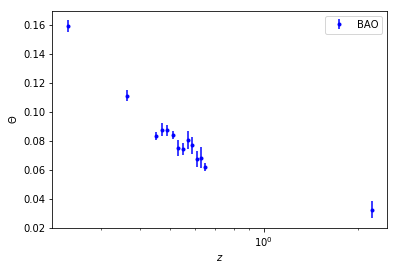

In [4]:
plt.xscale("log")
plt.ylabel(r"$\Theta$")
plt.xlabel(r"$z$")
plt.errorbar(z_bao, theta_bao, err_theta_bao, fmt="b.", label="BAO")
plt.legend();

### SN Ia

In [5]:
# Loading data
z_sn, m_obs, dm_obs_stat = np.loadtxt("Legacy.dat", unpack=True)

# Systematic error
dm_syst = 0.0169

# Combining errors
dm_obs = np.sqrt(dm_syst + dm_obs_stat ** 2)

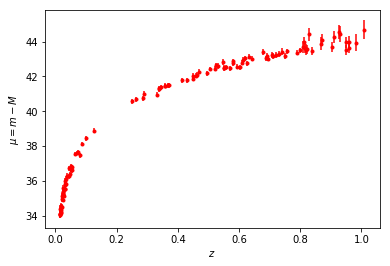

In [6]:
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu = m - M$")
plt.errorbar(z_sn, m_obs, dm_obs, fmt='r.' );

## Modelo

### Funções para modelar $\mu$ em função de $z$, $\Omega_{m0}$, $\Omega_{r0}$ e $h$

In [7]:
def luminosity_integrand(z, omgM, omgR):
    Ez = np.sqrt((1 - omgM) + omgM * np.power(1 + z, 3) + omgR * np.power(1 + z, 4))
    return 1. / Ez

def luminosity_distance(z, h, omgM, omgR):
    integral, _ = quad(luminosity_integrand, 0, z, epsrel=1e-8, args=(omgM, omgR))
    return (cte.c / 10. ** 5) / h * (1 + z) * integral

def distance_modulus(z, h, omgM, omgR):
    return 5. * np.log10(luminosity_distance(z, h, omgM, omgR)) + 25.

### Modelando $\Theta_{BAO}$ e $\Theta_{CMB}$

In [8]:
def E_inverse(z, omgM, omgR):
    Ez = np.sqrt((1 - omgM) + omgM * np.power(1 + z, 3) + omgR * np.power(1 + z, 4))
    return 1. / Ez

def sound_horizon_integrand(z, omgM, omgR, omgB, omgG):
    cs = np.power(3 + 9./4 * omgB / (omgG * z), -0.5)
    return cs * E_inverse(z, omgM, omgR)

def sound_horizon(z_star, omgM, omgR, omgB, omgG):
    integral, _ = quad(sound_horizon_integrand, z_star, np.inf, args=(omgM, omgR, omgB, omgG))
    return integral

def angular_distance(z, omgM, omgR):
    integral, _ = quad(E_inverse, 0, z, args=(omgM, omgR))
    return integral

def theta_model(z, z_star, omgM, omgR, omgB, omgG):
    return sound_horizon(z_star, omgM, omgR, omgB, omgG) / angular_distance(z, omgM, omgR)

## $\chi^2$ para diferentes datasets

In [9]:
def chisq_sn(h, omgM, omgR):
    m_model = np.array([distance_modulus(z, h, omgM, omgR) for z in z_sn])
    chisq_vec = np.power(((m_model - m_obs) / dm_obs), 2)
    return chisq_vec.sum()

def chisq_cmb(omgM, omgR, omgB, omgG):
    z_star_cmb = 1090
    theta_cmb_model = theta_model(z_ls, z_star_cmb, omgM, omgR, omgB, omgG)
    chisq = np.power( (theta_cmb_model - theta_cmb) / err_theta_cmb, 2 )
    return chisq

def chisq_bao(omgM, omgR, omgB, omgG):
    z_star_bao = 1060
    theta_bao_model = np.array([theta_model(z, z_star_bao, omgM, omgR, omgB, omgG) for z in z_bao])
    chisq = np.sum( np.power( (theta_bao_model - theta_bao) / err_theta_bao, 2 ) )
    return chisq

def chisq_cmb_bao(omgM, omgR, omgB, omgG):
    chisq = chisq_cmb(omgM, omgR, omgB, omgG) + \
            chisq_bao(omgM, omgR, omgB, omgG)
    return chishq

## Modelo fiducial

In [10]:
h_fid = 0.73
omgB_fid = 0.05
omgG_fid = 5e-5
omgR_fid = 8.4e-5
omgM_fid = 0.3

# Análise conjunta SNIa, CMB e BAO

## SNIa + BAO

### Solução de máxima verossimilhança

In [11]:
def chisq_sn_bao(pars):
    h, omgM = pars
    return chisq_bao(omgM, omgR_fid, omgB_fid, omgG_fid) + \
           chisq_sn(h, omgM, omgR_fid)

In [12]:
result_sn_bao = minimize(chisq_sn_bao, [h_fid, omgM_fid], bounds=((0.01, 1.), (0.01, 1.)))
h_sn_bao, omgM_sn_bao = result_sn_bao.x
print("Convergiu?: ", result_sn_bao.success)
print("chisq / dof = ", result_sn_bao.fun / (len(z_sn) + len(z_bao) - 2))
print("h = ", h_sn_bao)
print("omegaM = ",  omgM_sn_bao)

Convergiu?:  True
chisq / dof =  1.0254452654495687
h =  0.7075778128353615
omegaM =  0.22148486145831725


### Probabilidades a posteriori (curvas de contorno)

In [13]:
# Functions for priors and loglikelihoods
def lnprior(pars):
    h, omgM = pars
    if 0.0 < h and 0.0 < omgM < 1.0:
        return 0.0
    return -np.inf

def lnlike_sn_bao(pars):
    h, omgM = pars
    return -0.5 * chisq_sn_bao([h, omgM])

def lnprob_sn_bao(pars):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_sn_bao(pars)

In [14]:
# initial position at maximum likelihood values
ndim, nwalkers, nsteps = 2, 50, 1000
pos = [[h_sn_bao, omgM_sn_bao] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# MCMC chain with 50 walkers and 1000 steps
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_sn_bao, threads=4)
sampler.run_mcmc(pos, nsteps)

# Getting chains
h_sn_bao_chain = sampler.chain[:,:,0]
omgM_sn_bao_chain = sampler.chain[:,:,1]

# Average and standard deviation between chains
h_sn_bao_sn_bao_chain_mean = np.mean(h_sn_bao_chain, axis=0)
h_sn_bao_chain_std = np.std(h_sn_bao_chain, axis=0) / np.sqrt(nwalkers)

# Reshaping
h_sn_bao_chain_flat = np.reshape(h_sn_bao_chain, (nwalkers*nsteps,))
omgM_sn_bao_chain_flat = np.reshape(omgM_sn_bao_chain, (nwalkers*nsteps,))

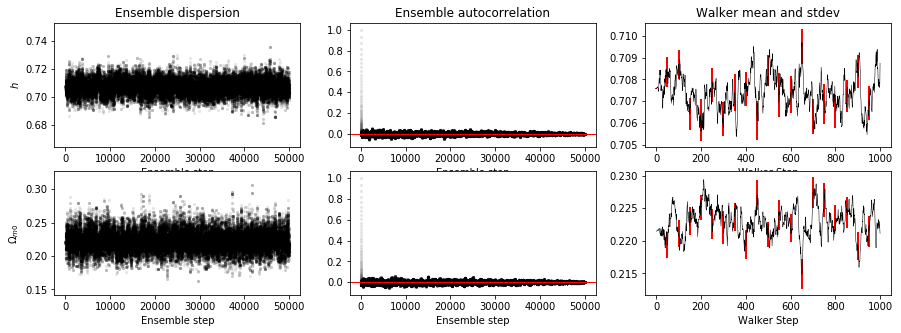

In [15]:
fig = plt.figure(figsize=(15, 5))
axs = fig.subplots(2, 3)

labels = [r"$h$", r"$\Omega_{m0}$"]
samples = np.c_[h_sn_bao_chain_flat, omgM_sn_bao_chain_flat].T
for i, par in enumerate(samples):
    axs[i][0].set_xlabel("Ensemble step")
    axs[i][1].set_xlabel("Ensemble step")
    axs[i][2].set_xlabel("Walker Step")
    axs[i][0].set_ylabel(labels[i])
    axs[0][0].set_title("Ensemble dispersion")
    axs[0][1].set_title("Ensemble autocorrelation")
    axs[0][2].set_title("Walker mean and stdev")
    idx = np.arange(len(par))
    axs[i][0].scatter(idx, par[idx], marker='o', c='k', s=10.0, alpha=0.1, linewidth=0)
    # Obtem autocorrelação usando emcee
    ac = emcee.autocorr.function(par)

    idx = np.arange(len(ac),step=1)
    axs[i][1].scatter(idx, ac[idx], marker='o', c='k', s=10.0, alpha=0.1, linewidth=0)
    axs[i][1].axhline(alpha=1., lw=1., color='red')

h_sn_bao_chain_mean = np.mean(h_sn_bao_chain, axis=0)
h_sn_bao_chain_err = np.std(h_sn_bao_chain, axis=0) / np.sqrt(nwalkers)
omgM_sn_bao_chain_mean = np.mean(omgM_sn_bao_chain, axis=0)
omgM_sn_bao_chain_err = np.std(omgM_sn_bao_chain, axis=0) / np.sqrt(nwalkers)
idx = np.arange(len(h_sn_bao_chain_mean))
axs[0][2].errorbar(x=idx, y=h_sn_bao_chain_mean, yerr=h_sn_bao_chain_err, errorevery=50, ecolor='red',
                   lw=0.5, elinewidth=2., color='k')
axs[1][2].errorbar(x=idx, y=omgM_sn_bao_chain_mean, yerr=omgM_sn_bao_chain_err, errorevery=50, ecolor='red',
                   lw=0.5, elinewidth=2., color='k');

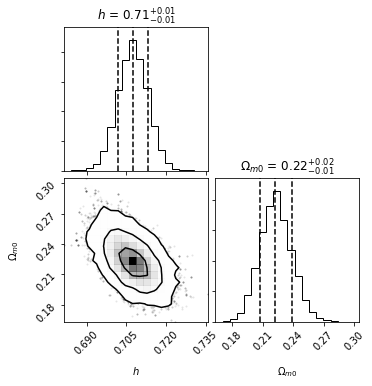

In [16]:
# corner plot
burn = 5000
samples_burned = np.c_[[par[burn:] for par in samples]]
fig = corner.corner(samples_burned.T, labels=labels,
                    quantiles=[0.16, 0.5, 0.84], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2), 1-np.exp(-9./2)), #1sigma, 2sigma and 3sigma contours
                    show_titles=True, title_kwargs={"fontsize": 12},
                    smooth1d=None, plot_contours=True,
                    no_fill_contours=False, plot_density=True,)

In [17]:
# Getting one-sigma intervals
samples[:, 2] = np.exp(samples[:, 2])
h_sn_bao_perc = np.percentile(samples[0], [16,50,84])
omgM_sn_bao_perc = np.percentile(samples[1], [16,50,84])

print(h_sn_bao_perc[1], h_sn_bao_perc[0] - h_sn_bao_perc[1], h_sn_bao_perc[2] - h_sn_bao_perc[1])
print(omgM_sn_bao_perc[1], omgM_sn_bao_perc[0] - omgM_sn_bao_perc[1], omgM_sn_bao_perc[2] - omgM_sn_bao_perc[1])

0.707427789837749 -0.005605152182618256 0.005572781252598413
0.22222848408501084 -0.014916377195591052 0.016287438087624256


$h = 0.707^{+0.006}_{-0.006} \qquad \Omega_{m0} = 0.222^{+0.016}_{-0.015}$

## SNIa + CMB

### Soluções de máxima verosimilhança

In [18]:
def chisq_sn_cmb(pars):
    h, omgM = pars
    return chisq_cmb(omgM, omgR_fid, omgB_fid, omgG_fid) + \
           chisq_sn(h, omgM, omgR_fid)

In [19]:
result_sn_cmb = minimize(chisq_sn_cmb, [h_fid, omgM_fid], bounds=((0.01, 1.), (0.01, 1.)))
h_sn_cmb, omgM_sn_cmb = result_sn_cmb.x
print("Convergiu?: ", result_sn_cmb.success)
print("chisq / dof = ", result_sn_cmb.fun / (len(z_sn) + 1 - 2))
print("h = ", h_sn_cmb)
print("omegaM = ",  omgM_sn_cmb)

Convergiu?:  True
chisq / dof =  1.0015908654242587
h =  0.6958228557980275
omegaM =  0.2889801573727629


In [20]:
# Functions for priors and loglikelihoods
def lnprior(pars):
    h, omgM = pars
    if 0.0 < h and 0.0 < omgM < 1.0:
        return 0.0
    return -np.inf

def lnlike_sn_cmb(pars):
    h, omgM = pars
    return -0.5 * chisq_sn_cmb([h, omgM])

def lnprob_sn_cmb(pars):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_sn_cmb(pars)

In [21]:
# initial position at maximum likelihood values
ndim, nwalkers, nsteps = 2, 50, 1000
pos = [[h_sn_cmb, omgM_sn_cmb] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# MCMC chain with 50 walkers and 1000 steps
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_sn_cmb, threads=4)
sampler.run_mcmc(pos, nsteps)

# Getting chains
h_sn_cmb_chain = sampler.chain[:,:,0]
omgM_sn_cmb_chain = sampler.chain[:,:,1]

# Average and standard deviation between chains
h_sn_cmb_chain_mean = np.mean(h_sn_cmb_chain, axis=0)
h_sn_cmb_chain_std = np.std(h_sn_cmb_chain, axis=0) / np.sqrt(nwalkers)

# Reshaping
h_sn_cmb_chain_flat = np.reshape(h_sn_cmb_chain, (nwalkers*nsteps,))
omgM_sn_cmb_chain_flat = np.reshape(omgM_sn_cmb_chain, (nwalkers*nsteps,))

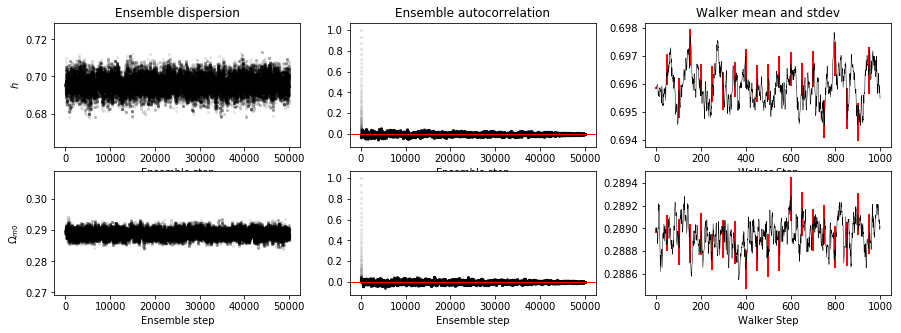

In [22]:
fig = plt.figure(figsize=(15, 5))
axs = fig.subplots(2, 3)

labels = [r"$h$", r"$\Omega_{m0}$"]
samples = np.c_[h_sn_cmb_chain_flat, omgM_sn_cmb_chain_flat].T
for i, par in enumerate(samples):
    axs[i][0].set_xlabel("Ensemble step")
    axs[i][1].set_xlabel("Ensemble step")
    axs[i][2].set_xlabel("Walker Step")
    axs[i][0].set_ylabel(labels[i])
    axs[0][0].set_title("Ensemble dispersion")
    axs[0][1].set_title("Ensemble autocorrelation")
    axs[0][2].set_title("Walker mean and stdev")
    idx = np.arange(len(par))
    axs[i][0].scatter(idx, par[idx], marker='o', c='k', s=10.0, alpha=0.1, linewidth=0)
    # Obtem autocorrelação usando emcee
    ac = emcee.autocorr.function(par)

    idx = np.arange(len(ac),step=1)
    axs[i][1].scatter(idx, ac[idx], marker='o', c='k', s=10.0, alpha=0.1, linewidth=0)
    axs[i][1].axhline(alpha=1., lw=1., color='red')

h_sn_cmb_chain_mean = np.mean(h_sn_cmb_chain, axis=0)
h_sn_cmb_chain_err = np.std(h_sn_cmb_chain, axis=0) / np.sqrt(nwalkers)
omgM_sn_cmb_chain_mean = np.mean(omgM_sn_cmb_chain, axis=0)
omgM_sn_cmb_chain_err = np.std(omgM_sn_cmb_chain, axis=0) / np.sqrt(nwalkers)
idx = np.arange(len(h_sn_cmb_chain_mean))
axs[0][2].errorbar(x=idx, y=h_sn_cmb_chain_mean, yerr=h_sn_cmb_chain_err, errorevery=50, ecolor='red',
                   lw=0.5, elinewidth=2., color='k')
axs[1][2].errorbar(x=idx, y=omgM_sn_cmb_chain_mean, yerr=omgM_sn_cmb_chain_err, errorevery=50, ecolor='red',
                   lw=0.5, elinewidth=2., color='k');

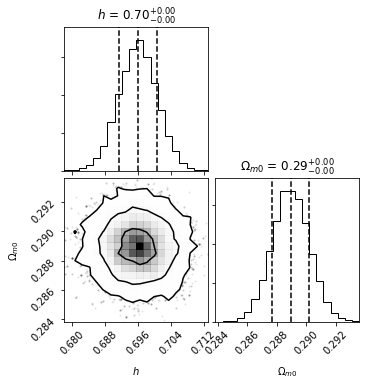

In [23]:
# corner plot
burn = 5000
samples_burned = np.c_[[par[burn:] for par in samples]]
fig = corner.corner(samples_burned.T, labels=labels,
                    quantiles=[0.16, 0.5, 0.84], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2), 1-np.exp(-9./2)), #1sigma, 2sigma and 3sigma contours
                    show_titles=True, title_kwargs={"fontsize": 12},
                    smooth1d=None, plot_contours=True,
                    no_fill_contours=False, plot_density=True,)

In [24]:
# Getting one-sigma intervals
samples[:, 2] = np.exp(samples[:, 2])
h_sn_cmb_perc = np.percentile(samples[0], [16,50,84])
omgM_sn_cmb_perc = np.percentile(samples[1], [16,50,84])

print(h_sn_cmb_perc[1], h_sn_cmb_perc[0] - h_sn_cmb_perc[1], h_sn_cmb_perc[2] - h_sn_cmb_perc[1])
print(omgM_sn_cmb_perc[1], omgM_sn_cmb_perc[0] - omgM_sn_cmb_perc[1], omgM_sn_cmb_perc[2] - omgM_sn_cmb_perc[1])

0.6959362543058362 -0.00466746430013909 0.004583390690626077
0.2889299279274299 -0.0012471174724633105 0.0012700723185551377


$h = 0.696^{+0.005}_{-0.005} \qquad \Omega_{m0} = 0.289^{+0.001}_{-0.001}$